In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Flatten, Dropout, ZeroPadding3D
from keras.layers import LSTM, Bidirectional
from keras.models import Sequential, load_model
from keras.optimizers import Adam, RMSprop
from keras.layers import TimeDistributed, Activation, MaxPooling1D, Embedding
from keras.layers.convolutional import (Conv2D, MaxPooling3D, Conv3D,
    MaxPooling2D)
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, roc_auc_score, auc, precision_recall_curve, f1_score

In [2]:
class CONFIG:
    TRAIN_DATA_PATH = '../capture/TRAIN_TEST/train/train.csv'
    TEST_DATA_PATH = '../capture/TRAIN_TEST/val/test.csv'

In [3]:
#Define train test
df_train = pd.read_csv(CONFIG.TRAIN_DATA_PATH)
df_test = pd.read_csv(CONFIG.TEST_DATA_PATH)

In [4]:
df_train.head()

,label,pixels_1,pixels_2,pixels_3,pixels_4,pixels_5,pixels_6,pixels_7,pixels_8,pixels_9,...,pixels_4087,pixels_4088,pixels_4089,pixels_4090,pixels_4091,pixels_4092,pixels_4093,pixels_4094,pixels_4095,pixels_4096
0,0,156,156,159,156,155,160,159,159,160,...,43,42,43,42,43,43,46,42,38,39
1,0,173,176,175,174,174,173,173,172,172,...,34,36,45,43,41,37,43,40,44,48
2,0,156,157,158,157,156,158,157,160,164,...,40,41,41,41,40,45,44,42,44,43
3,0,219,219,220,219,220,221,222,223,224,...,2,7,24,25,32,35,33,35,38,33
4,0,221,220,222,221,222,219,219,221,220,...,20,5,2,10,20,31,35,36,34,34


In [5]:
df_test

,label,pixels_1,pixels_2,pixels_3,pixels_4,pixels_5,pixels_6,pixels_7,pixels_8,pixels_9,...,pixels_4087,pixels_4088,pixels_4089,pixels_4090,pixels_4091,pixels_4092,pixels_4093,pixels_4094,pixels_4095,pixels_4096
0,0,218,220,218,218,219,220,221,222,222,...,8,3,7,23,29,28,30,34,37,35
1,0,221,223,222,222,223,224,225,223,225,...,29,27,32,34,34,29,30,28,27,28
2,0,233,235,235,235,236,236,235,235,236,...,158,158,154,160,161,155,142,130,126,127
3,0,174,175,174,176,174,174,176,176,176,...,39,38,39,39,40,40,42,47,46,46
4,0,123,118,111,111,107,106,105,96,58,...,22,13,12,45,76,87,94,92,61,51
5,0,187,186,187,187,188,188,189,189,191,...,47,49,50,51,51,53,53,54,58,59
6,0,133,131,129,128,130,133,136,136,131,...,29,91,107,116,115,91,70,71,72,78
7,0,168,170,172,173,174,175,176,177,179,...,55,58,60,60,59,57,57,60,60,60
8,0,219,219,225,219,216,218,217,217,211,...,95,100,103,106,110,116,116,128,141,157
9,0,114,112,115,118,118,117,119,119,121,...,48,48,54,52,55,56,55,56,57,65


In [6]:
#preprocess
y_train = df_train['label']
y_test = df_test['label']

In [7]:
x_train = df_train.drop(columns=['label'], axis=1)
x_test = df_test.drop(columns=['label'], axis=1)

In [8]:
x_train = x_train.values
x_test = x_test.values

In [9]:
#normalize
x_train = x_train/255
x_test = x_test/255

In [10]:
x_train.shape

(139, 4096)

In [11]:
#reshape to 3D
x_train = x_train.reshape(-1, 64, 64, 1)
x_test = x_test.reshape(-1, 64, 64, 1)

In [12]:
print(x_train.shape)
print(x_test.shape)

(139, 64, 64, 1)
(36, 64, 64, 1)


In [13]:
#augmentation
datagenerator = ImageDataGenerator(
    rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range=0.1,  # Randomly zoom image
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=True,    # randomly flip images
)

train_data = datagenerator.flow(x_train, y_train)

In [14]:
train_data
# print(test_data.shape)

In [15]:
cnn = Sequential([
    Conv2D(filters=16, kernel_size=(3,3), input_shape=(64,64,1), activation='relu', padding='same'),
    MaxPooling2D((2,2)),
    Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same'),
    MaxPooling2D((2,2)),
    Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(108, activation='relu'),
    Dense(1, activation='sigmoid')
])

optimizer = Adam(lr=0.001)
cnn.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 16)        2320      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 32)        4640      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 8, 8, 32)         0

c:\Users\Hanif\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [16]:
history = cnn.fit(train_data,
batch_size=8,
epochs=100,
validation_data=(x_test, y_test))

Epoch 1/100
5/5 [==============================] - 1s 90ms/step - loss: 0.7344 - accuracy: 0.5108 - val_loss: 0.7124 - val_accuracy: 0.5000
Epoch 2/100
5/5 [==============================] - 0s 43ms/step - loss: 0.7097 - accuracy: 0.4388 - val_loss: 0.6923 - val_accuracy: 0.5000
Epoch 3/100
5/5 [==============================] - 0s 45ms/step - loss: 0.6933 - accuracy: 0.4892 - val_loss: 0.6914 - val_accuracy: 0.5278
Epoch 4/100
5/5 [==============================] - 0s 49ms/step - loss: 0.6929 - accuracy: 0.4748 - val_loss: 0.6916 - val_accuracy: 0.5000
Epoch 5/100
5/5 [==============================] - 0s 47ms/step - loss: 0.6919 - accuracy: 0.5108 - val_loss: 0.6911 - val_accuracy: 0.5278
Epoch 6/100
5/5 [==============================] - 0s 43ms/step - loss: 0.6921 - accuracy: 0.5180 - val_loss: 0.6911 - val_accuracy: 0.5833
Epoch 7/100
5/5 [==============================] - 0s 44ms/step - loss: 0.6898 - accuracy: 0.6331 - val_loss: 0.6908 - val_accuracy: 0.5833
Epoch 8/100
5/5 [===

<AxesSubplot:>

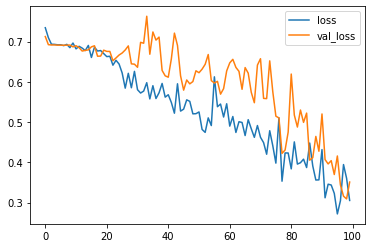

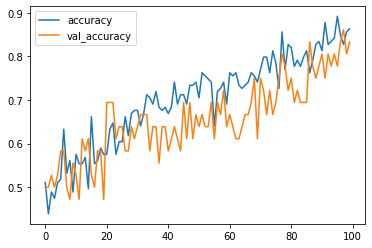

In [17]:
losses = pd.DataFrame(cnn.history.history)
losses[['loss','val_loss']].plot()
losses[['accuracy','val_accuracy']].plot()

In [18]:
#Model Evaluation
y_pred = cnn.predict(x_test)
y_pred_classes = [np.argmax(element) for element in y_pred]

print("Classification Report: \n", classification_report(y_test, y_pred_classes))

2/2 [==============================] - 0s 5ms/step
Classification Report: 
               precision    recall  f1-score   support

           0       0.50      1.00      0.67        18
           1       0.00      0.00      0.00        18

    accuracy                           0.50        36
   macro avg       0.25      0.50      0.33        36
weighted avg       0.25      0.50      0.33        36



c:\Users\Hanif\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Hanif\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Hanif\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [19]:
#ROC dan AUC

#preds = cnn.predict(x_test)
fpr, tpr, threshold = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

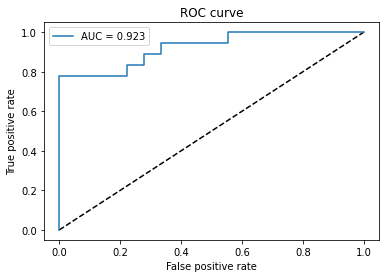

In [20]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='AUC = {:.3f}'.format(roc_auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [21]:
#CNN yang dipake

cnn = Sequential([
    Conv2D(filters=16, kernel_size=(3,3), input_shape=(64,64,1), activation='relu', padding='same'),
    MaxPooling2D((2,2)),
    Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(108, activation='relu'),
    Dense(1, activation='sigmoid')
])

optimizer = Adam(lr=0.001)
cnn.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 64, 64, 16)        160       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 32, 32, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_3 (Dense)             (None, 512)              

c:\Users\Hanif\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [22]:
history = cnn.fit(train_data,
batch_size=8,
epochs=100,
validation_data=(x_test, y_test))

Epoch 1/100
5/5 [==============================] - 1s 114ms/step - loss: 0.8371 - accuracy: 0.4820 - val_loss: 0.7057 - val_accuracy: 0.5000
Epoch 2/100
5/5 [==============================] - 0s 52ms/step - loss: 0.7106 - accuracy: 0.4245 - val_loss: 0.6930 - val_accuracy: 0.5000
Epoch 3/100
5/5 [==============================] - 0s 53ms/step - loss: 0.6958 - accuracy: 0.4820 - val_loss: 0.6935 - val_accuracy: 0.5000
Epoch 4/100
5/5 [==============================] - 0s 68ms/step - loss: 0.6922 - accuracy: 0.5108 - val_loss: 0.6923 - val_accuracy: 0.5000
Epoch 5/100
5/5 [==============================] - 0s 62ms/step - loss: 0.6907 - accuracy: 0.5108 - val_loss: 0.6927 - val_accuracy: 0.5000
Epoch 6/100
5/5 [==============================] - 0s 51ms/step - loss: 0.6901 - accuracy: 0.5108 - val_loss: 0.6915 - val_accuracy: 0.5278
Epoch 7/100
5/5 [==============================] - 0s 52ms/step - loss: 0.6893 - accuracy: 0.5252 - val_loss: 0.6904 - val_accuracy: 0.4722
Epoch 8/100
5/5 [==

<AxesSubplot:>

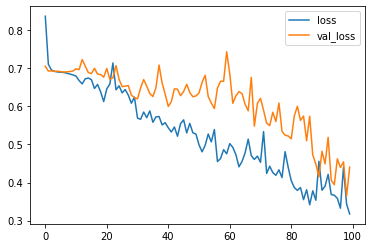

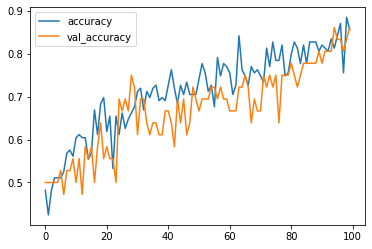

In [23]:
losses = pd.DataFrame(cnn.history.history)
losses[['loss','val_loss']].plot()
losses[['accuracy','val_accuracy']].plot()

In [32]:
# Prints out test loss and accuracy
results_test = cnn.evaluate(x_test, y_test)
print(results_test)
# Creates a classification report showing your accuracy, recall, f1.
y_pred = cnn.predict(x_test)
y_predict = np.round(y_pred).astype(int)
print(classification_report(y_test, y_predict))
# print(confusion_matrix(y_test, y_predict))

2/2 [==============================] - 0s 7ms/step - loss: 0.4405 - accuracy: 0.8611
[0.44050735235214233, 0.8611111044883728]
2/2 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

           0       0.78      1.00      0.88        18
           1       1.00      0.72      0.84        18

    accuracy                           0.86        36
   macro avg       0.89      0.86      0.86        36
weighted avg       0.89      0.86      0.86        36



In [33]:
#ROC dan AUC

#preds = cnn.predict(x_test)
fpr, tpr, threshold = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

TypeError: 'numpy.float64' object is not callable

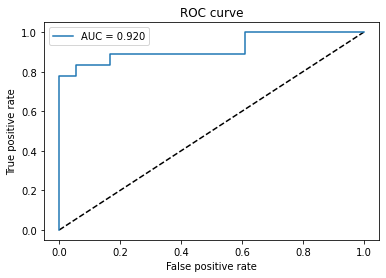

In [34]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='AUC = {:.3f}'.format(roc_auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [31]:


# calculate precision-recall curve
precision, recall, _ = precision_recall_curve(y_test, y_predict)
f1, auc = f1_score(y_test, y_predict), auc(recall, precision)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (f1, auc))
# plot the precision-recall curves
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='CNN')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

TypeError: 'numpy.float64' object is not callable